# Comparing sensitive vs resistant RNA-seq data for isolines PEO, PEA, OVCAR3, and OVCAR4 to known mechanisms of resistant

Note: Works with Python 3.11, issues with Python 3.12.

## Introduction

Goal: to see which, if any, of the isogenic lines show highly differential activity in the genes involved in known mechanisms of resistance when considering resistant and non-resistant cell-lines.

RNA-seq was run for three isogenic tumor cell lines (PEO1, PEO4, and PEO6)
Sample preparation was performed in Dr. Lang's lab. Preparation of cells and RNA extraction was done by Kendra, Josie, and Sydney.
RNA seq library prep was done by Kristen.

Data on known mechanisms of resistance from https://www.nature.com/articles/s41388-021-02055-2#Sec39 Supplemental Table 1

Use ` jupyter nbconvert --to html prev_literature_resistance_mechanisms.ipynb` to export notebook to a `.html` file

## Inputs

- Up and downregulated gene lists
- Metadata table
  
### Imports

In [1]:
import pandas as pd
from IPython.display import display
import math
import plotnine as p9
import numpy as np
from adjustText import adjust_text
from collections import Counter
import warnings
import matplotlib.pyplot as plt
import textwrap

In [2]:
known_mechanisms_excel_file = "prev_literature_pt_resistance_genes.xlsx"
known_mechanism_groups_excel_file = (
    "prev_literature_resistance_mechanisms_groupings.xlsx"
)
differential_rnaseq_input_folder = "../output"


class Isoline:
    def __init__(self, name, sensitive_line, resistant_lines):
        self.name = name
        self.sensitive_line = sensitive_line
        self.resistant_lines = resistant_lines
        self.all_lines = resistant_lines.copy()
        self.all_lines.append(sensitive_line)


isolines = [
    Isoline("OVCAR3", "OVCAR3", ["OVCAR3-ResA", "OVCAR3-ResB"]),
    Isoline("OVCAR4", "OVCAR4", ["OVCAR4-ResA", "OVCAR4-ResB"]),
    Isoline("PEO", "PEO1", ["PEO4", "PEO6"]),
    Isoline("PEA", "PEA1", ["PEA2"]),
]

## Read in known mechanisms of platinum resistance

From documentation of table sourcing data:
- a) possible mechanism related to resistance
- b) notes from cited papers
- c) whether gene expression is up or downregulated in pt-resistant cells/tissues
- d) whether an up/down regulation of the gene promotes platinum resistance
- e) whether an exposure to platinum treatment upregulates or downregulates gene expression
- f) target of an approved drug
- g) score is strength of evidence

TODO: What is the difference between mechanisms separated by commas and mechanasisms separated by "/"

In [3]:
known_mechanisms_raw = pd.read_excel(known_mechanisms_excel_file)
# display(known_mechanisms_raw)

known_mechanisms = known_mechanisms_raw.copy()
known_mechanisms = known_mechanisms.rename(
    columns={
        "HUGO Gene symbol": "gene",
        "Putative mechanism associated with Pt-resistancea": "mechanisms",
        "Up / down in Pt-resistant cellsc": "dir_correlated_to_resistance",
        "Up / down to promote Pt-resistanced": "dir_causal_to_resistance",
        "Up / down after Pt-treatmente": "dir_after_treatment",
        "Druggablef": "druggable",
        "Scores": "score",
    }
)

known_mechanisms = known_mechanisms[
    [
        "gene",
        "mechanisms",
        "dir_correlated_to_resistance",
        "dir_causal_to_resistance",
        "dir_after_treatment",
        "druggable",
        "score",
    ]
]

# Split each row with multiple mechanisms into multiple rows each with one mechanism
known_mechanisms = (
    known_mechanisms.assign(mechanisms=known_mechanisms.mechanisms.str.split(", "))
    .explode("mechanisms")
    .reset_index(drop=True)
)

# Assign the direction of gene expression for resistance based on dir_correlated_to_resistance and dir_causal_to_resistance
for row in known_mechanisms.itertuples():
    up_found = (
        "UP" in row.dir_correlated_to_resistance or "UP" in row.dir_causal_to_resistance
    )
    down_found = (
        "DOWN" in row.dir_correlated_to_resistance
        or "DOWN" in row.dir_causal_to_resistance
    )
    dir = "UNKNOWN"

    if up_found and not down_found:
        dir = "UP"
    elif down_found and not up_found:
        dir = "DOWN"

    known_mechanisms.at[row.Index, "dir"] = dir

display(known_mechanisms)

,gene,mechanisms,dir_correlated_to_resistance,dir_causal_to_resistance,dir_after_treatment,druggable,score,dir
0,AATF,Apoptotic signaling,UP,UP,UP,NaN,1,UP
1,AATF,DDR,UP,UP,UP,NaN,1,UP
2,AATF,p53 signaling,UP,UP,UP,NaN,1,UP
3,ABCA8,Platinum efflux,UP,UP,UP,NaN,1,UP
4,ABCB1,Platinum efflux,UP,UP,UNCHANGED in S; UP in R,Yes,4,UP
...,...,...,...,...,...,...,...,...
1859,ZNF143,Apoptotic signaling,UP,UP,UNKNOWN,NaN,1,UP
1860,ZNF143,DDR,UP,UP,UNKNOWN,NaN,1,UP
1861,ZNF143,Transcription,UP,UP,UNKNOWN,NaN,1,UP
1862,ZNF93,MYC signaling,UP,UP,UNKNOWN,NaN,1,UP


### Categorize known mechanisms into 7 main groups

Groupings defined by Jessi, largely influenced by paper giving known mechanisms

In [4]:
known_mechanism_groups = pd.read_excel(known_mechanism_groups_excel_file)
known_mechanisms["group"] = ""

for index, row in known_mechanisms.iterrows():
    belongs_to_groups = []
    for group in known_mechanism_groups.columns:
        if row.mechanisms in known_mechanism_groups[group].values:
            belongs_to_groups.append(group)
    if len(belongs_to_groups) > 0:
        known_mechanisms.at[index, "group"] = "; ".join(belongs_to_groups)

# Remove mechanisms not assigned a group (e.g., "bystander affect")
known_mechanisms = known_mechanisms[known_mechanisms["group"] != ""].reset_index(
    drop=True
)

# Split each row with multiple groups into multiple rows each with one group
known_mechanisms = (
    known_mechanisms.assign(group=known_mechanisms.group.str.split("; "))
    .explode("group")
    .reset_index(drop=True)
)
display(known_mechanisms)

,gene,mechanisms,dir_correlated_to_resistance,dir_causal_to_resistance,dir_after_treatment,druggable,score,dir,group
0,AATF,Apoptotic signaling,UP,UP,UP,NaN,1,UP,"Inhibition of apoptotic signaling, downregulat..."
1,AATF,DDR,UP,UP,UP,NaN,1,UP,Enhanced repair and tolerance of platinum indu...
2,AATF,p53 signaling,UP,UP,UP,NaN,1,UP,Enhanced repair and tolerance of platinum indu...
3,ABCA8,Platinum efflux,UP,UP,UP,NaN,1,UP,"Reduced importation and increased exportation,..."
4,ABCB1,Platinum efflux,UP,UP,UNCHANGED in S; UP in R,Yes,4,UP,"Reduced importation and increased exportation,..."
...,...,...,...,...,...,...,...,...,...
1858,ZNF143,Apoptotic signaling,UP,UP,UNKNOWN,NaN,1,UP,"Inhibition of apoptotic signaling, downregulat..."
1859,ZNF143,DDR,UP,UP,UNKNOWN,NaN,1,UP,Enhanced repair and tolerance of platinum indu...
1860,ZNF143,Transcription,UP,UP,UNKNOWN,NaN,1,UP,Upregulation of key signaling pathways promoti...
1861,ZNF93,MYC signaling,UP,UP,UNKNOWN,NaN,1,UP,Upregulation of key signaling pathways promoti...


### Display all known mechanisms

In [5]:
# Count the occurrences of each mechanism
mechanism_counts = Counter(known_mechanisms["mechanisms"])

# Convert the mechanism counts to a DataFrame
mechanism_counts_df = (
    pd.DataFrame(list(mechanism_counts.items()), columns=["mechanism", "num_genes"])
    .sort_values(by="num_genes", ascending=False)
    .reset_index(drop=True)
)

# Display the DataFrame with mechanism counts
display(mechanism_counts_df)
print(mechanism_counts_df["mechanism"].tolist())

,mechanism,num_genes
0,Apoptotic signaling,106
1,ECM signaling,94
2,Immune response,93
3,CSC,83
4,EMT,71
...,...,...
78,exocytosis,1
79,Metabolism/cholesterol,1
80,mitochondria/DNA,1
81,OXPHOS,1


['Apoptotic signaling', 'ECM signaling', 'Immune response', 'CSC', 'EMT', 'DDR/HR', 'Cell cycle', 'Redox', 'Oncogene signaling', 'DDR', 'WNT signaling', 'NF-kB signaling', 'p53 signaling', 'Oncogene signaling/AKT', 'Platinum efflux', 'Transcription', 'Autophagy', 'Oncogene signaling/MAPK', 'Apoptosis', 'TGF-β signaling', 'Redox/Glutathione', 'Hypoxia signaling', 'DDR/NER', 'Oncogene signaling/EGFR', 'Metabolism/OXPHOS', 'Platinum uptake', 'DDR/FA', 'Translation', 'Transcription/Epigenetics', 'RNA processing', 'PKA signaling', 'mTOR signaling', 'Hippo signaling', 'Apoptotic signaling/MAPK', 'ubiquitin', 'ER stress response', 'Metabolism/Glycolysis', 'AMPK signaling', 'Chaperone', 'DDR/BER', 'DDR/nucleotide synthesis', 'Notch signaling', 'DDR/NHEJ', 'Apoptotic signaling/DR', 'Metabolism/Lipid', 'MYC signaling', 'Calcium signaling', 'DDR/TLS', 'DDR/DNA replication', 'Detox', 'Hedgehog signaling', 'pH/Pt-toxicity', 'DDR/MMR', 'Metabolism/amino acid', 'Oncogene signaling/VEGF', 'Metabolism/

## Display all known groups of mechanisms

In [6]:
# Count the occurrences of each group
group_counts = Counter(known_mechanisms["group"])

# Convert the group counts to a DataFrame
group_counts_df = pd.DataFrame(
    list(group_counts.items()), columns=["group of mechanisms", "num_genes"]
).sort_values(by="num_genes", ascending=False).reset_index(drop = True)

# Display the DataFrame with group counts
display(group_counts_df)

,group of mechanisms,num_genes
0,Upregulation of key signaling pathways promoti...,641
1,Enhanced repair and tolerance of platinum indu...,368
2,"Inhibition of apoptotic signaling, downregulat...",329
3,Extracellular mechanisms that alter the extrac...,263
4,"Reduced importation and increased exportation,...",98
5,Metabolic reprogramming,85
6,Hypoxia and other stress responses (e.g. ER st...,79


## Volcano plots for each group of mechanisms and sensitive/resistant pair

Dir of gene for mechanism group = UP/DOWN if dir for all entries match; UNKNOWN otherwise
Score of gene for mechanism group = max score of gene for mechanism within group

In [7]:
# Volcano plot for a given mechanism group and isoline
def volcano_plot_mechanism(group, sensitive_line, cellline):
    # Read in differential rnaseq data
    pair = f"{cellline}_vs_{sensitive_line}"
    rnaseq_pair = pair.replace("-Res", "")
    cellline_rnaseq_df = pd.read_csv(
        f"{differential_rnaseq_input_folder}/{rnaseq_pair}_deseq_results.csv",
        sep=",",
        index_col=0,
    )

    # Keep only the genes that are in the group of mechanisms of interest
    relevant_genes = known_mechanisms[known_mechanisms.group == group].gene
    volcano_plot_data = cellline_rnaseq_df[
        cellline_rnaseq_df.index.isin(relevant_genes)
    ]

    # Format plot data
    volcano_plot_data = volcano_plot_data.dropna(subset=["padj", "log2FoldChange"])
    volcano_plot_data["gene"] = volcano_plot_data.index
    volcano_plot_data["-log10padj"] = -np.log10(volcano_plot_data["padj"])
    volcano_plot_data = volcano_plot_data[["-log10padj", "log2FoldChange", "gene"]]
    # set score based on score in known_mechanisms
    volcano_plot_data["score (importance to mechanism)"] = volcano_plot_data[
        "gene"
    ].apply(lambda x: known_mechanisms[known_mechanisms["gene"] == x].score.max())
    # set direction based on dir in known_mechanisms
    def get_direction(x):
        directions = known_mechanisms[known_mechanisms["gene"] == x].dir.unique()
        if len(directions) == 1:
            return directions[0]
        else:
            return "UNKNOWN"
    volcano_plot_data["dir"] = volcano_plot_data["gene"].apply(
        get_direction
    )
    # set with/against resistance based on dir and actual direction of change
    def with_against_resistance(row):
        if row["dir"] == "UP" and row["log2FoldChange"] > 0:
            return "WITH"
        elif row["dir"] == "UP" and row["log2FoldChange"] < 0:
            return "AGAINST"
        elif row["dir"] == "DOWN" and row["log2FoldChange"] < 0:
            return "WITH"
        elif row["dir"] == "DOWN" and row["log2FoldChange"] > 0:
            return "AGAINST"
        else:
            return "UNKNOWN"
    volcano_plot_data["with/against resistance"] = volcano_plot_data.apply(
        lambda row: with_against_resistance(row), axis=1
    )

    # Compute x and y limits so that they are consistent across all mechanism groups within this cellline
    relevant_genes = known_mechanisms.gene
    plot_limit_data = cellline_rnaseq_df[cellline_rnaseq_df.index.isin(relevant_genes)]
    plot_limit_data = plot_limit_data.dropna(subset=["padj", "log2FoldChange"])
    plot_limit_data = plot_limit_data[["padj", "log2FoldChange"]]
    plot_limit_data["-log10padj"] = -np.log10(plot_limit_data["padj"])
    x_min = math.floor(plot_limit_data["log2FoldChange"].min())
    x_min = x_min - abs(x_min) * 0.05
    x_max = math.ceil(plot_limit_data["log2FoldChange"].max())
    x_max = x_max + abs(x_max) * 0.05
    y_min = math.floor(plot_limit_data["-log10padj"].min())
    y_min = y_min - abs(y_min) * 0.05
    y_max = math.ceil(plot_limit_data["-log10padj"].max())
    y_max = y_max + abs(y_max) * 0.05

    # Wrap the text of the title appropriately
    wrapped_title = textwrap.fill(f"{group}", 50)
    while wrapped_title.count('\n') < 3:
        wrapped_title += '\n'

    # Plot
    plot = (
        p9.ggplot(
            volcano_plot_data,
            p9.aes(
                x="log2FoldChange",
                y="-log10padj",
                color="with/against resistance",
                size="score (importance to mechanism)",
                # label="gene", # Plotting label separately so that the size isn't affected by score
            ),
        )
        + p9.geom_point(alpha=0.5)
        + p9.scale_color_manual(
            values={"WITH": "green", "AGAINST": "red", "UNKNOWN": "gray"}
        )
        + p9.geom_text(
            p9.aes(label="gene"),
            size=10,
            nudge_x=1,
            data = volcano_plot_data[(volcano_plot_data["-log10padj"] > 1.3) & (volcano_plot_data["log2FoldChange"].abs() > 1.2)]
        )
        + p9.scale_size_continuous(range=[2.5, 5])
        + p9.theme_bw()
        + p9.theme(
            figure_size=(8, 8),
            plot_title=p9.element_text(size=20),
            axis_title=p9.element_text(size=15),
            legend_position="none", # Comment to get legend (and adjust fig size)
        )
        + p9.labs(
            x="log2 fold change",
            y="-log10 adjusted p-value",
            title=wrapped_title,
            # title=f"Volcano plot for genes related to \n{group} \nin {cellline} vs {sensitive_line}",
        )
        + p9.geom_vline(xintercept=-1.2, linetype="dashed", color="gray")
        + p9.geom_vline(xintercept=+1.2, linetype="dashed", color="gray")
        + p9.geom_hline(yintercept=1.301, linetype="dashed", color="gray")
        + p9.xlim(x_min, x_max)
        + p9.ylim(y_min, y_max)
    )
    return plot

Note: Green indicates that the regulation we saw is in the same direction as the regulation known to be correlated with resistance. Red indicates that the regulation we saw is opposite the direction known to be correlated with resistance. Gray is when there is conflicting evidence or it is otherwise unclear whether the gene being up or downregulated is known to be correlated with resistance. So, if a resistant cellline's mechanism closely follows a known mechanism, we would expect the plot to have mostly green points.

OVCAR3-ResA vs OVCAR3



/Users/Ryan/venv/general_purpose_venv/lib/python3.12/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 8 x 8 in image.
/Users/Ryan/venv/general_purpose_venv/lib/python3.12/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: plots/OVCAR3-ResA_vs_OVCAR3_Upregulation of key signaling pathways promoting resistance.svg
/Users/Ryan/venv/general_purpose_venv/lib/python3.12/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 8 x 8 in image.
/Users/Ryan/venv/general_purpose_venv/lib/python3.12/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: plots/OVCAR3-ResA_vs_OVCAR3_Enhanced repair and tolerance of platinum induced DNA damage and blockage of cell cycle inhibition.svg
/Users/Ryan/venv/general_purpose_venv/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_text : Removed 1 rows containing missing values.
/Users/Ryan/venv/general_purpose_venv/lib/python3.12/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 8 x

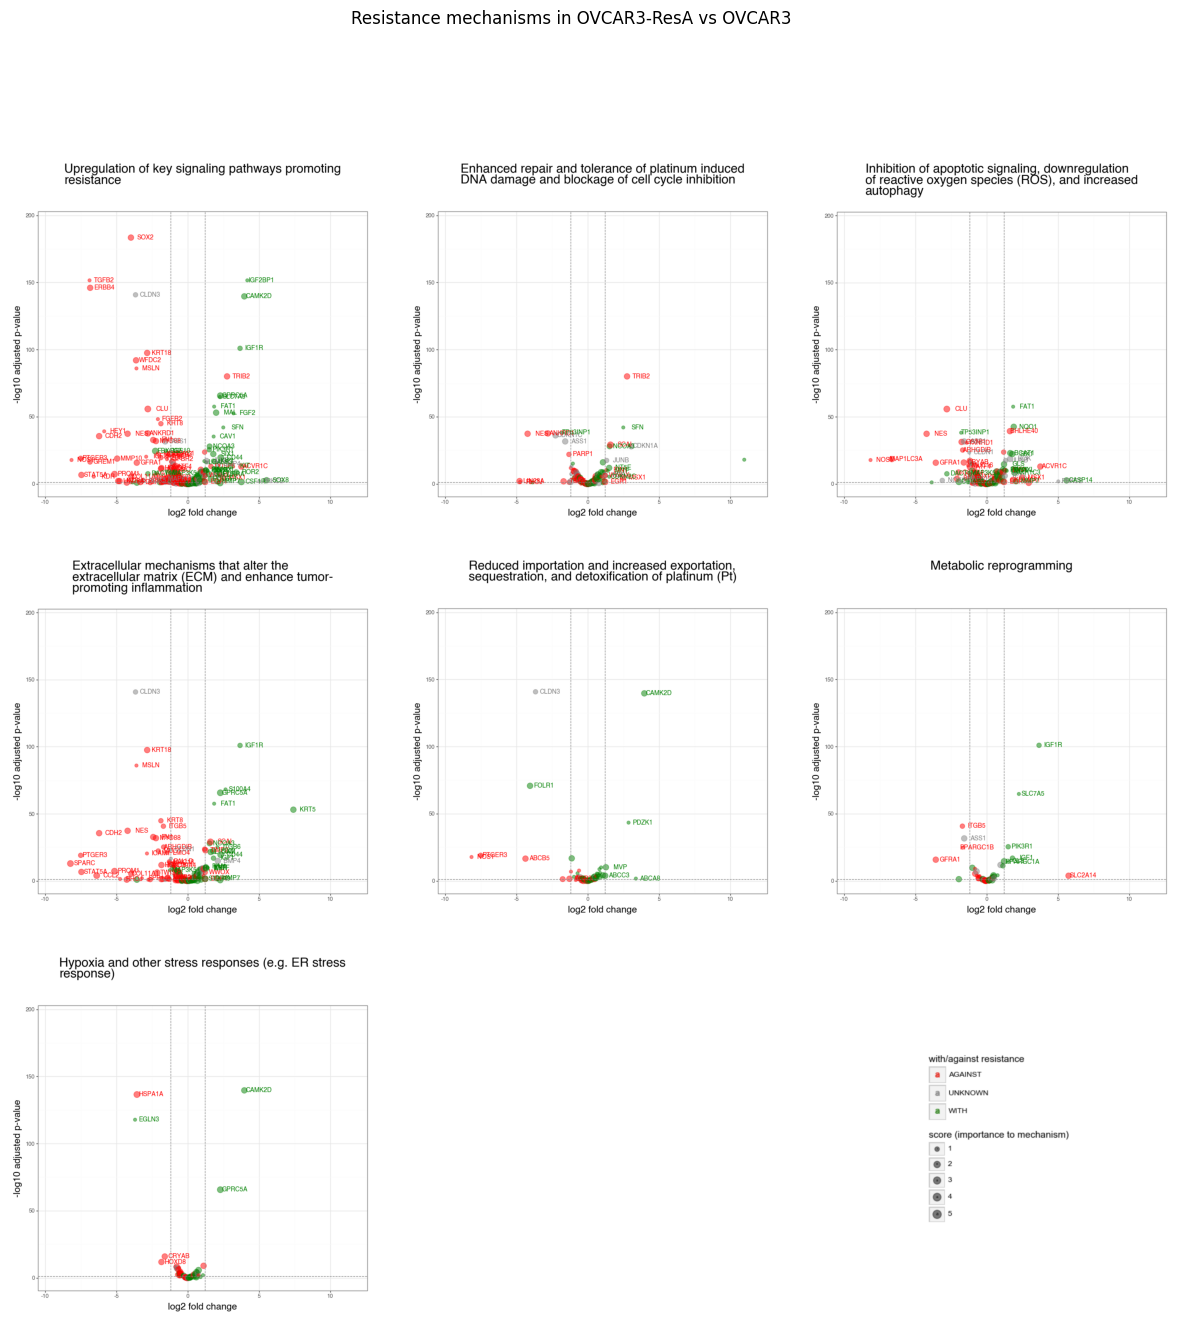

OVCAR3-ResB vs OVCAR3



/Users/Ryan/venv/general_purpose_venv/lib/python3.12/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 8 x 8 in image.
/Users/Ryan/venv/general_purpose_venv/lib/python3.12/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: plots/OVCAR3-ResB_vs_OVCAR3_Upregulation of key signaling pathways promoting resistance.svg
/Users/Ryan/venv/general_purpose_venv/lib/python3.12/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 8 x 8 in image.
/Users/Ryan/venv/general_purpose_venv/lib/python3.12/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: plots/OVCAR3-ResB_vs_OVCAR3_Enhanced repair and tolerance of platinum induced DNA damage and blockage of cell cycle inhibition.svg
/Users/Ryan/venv/general_purpose_venv/lib/python3.12/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 8 x 8 in image.
/Users/Ryan/venv/general_purpose_venv/lib/python3.12/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: plots/OVCAR3-ResB_vs_OVCAR3_In

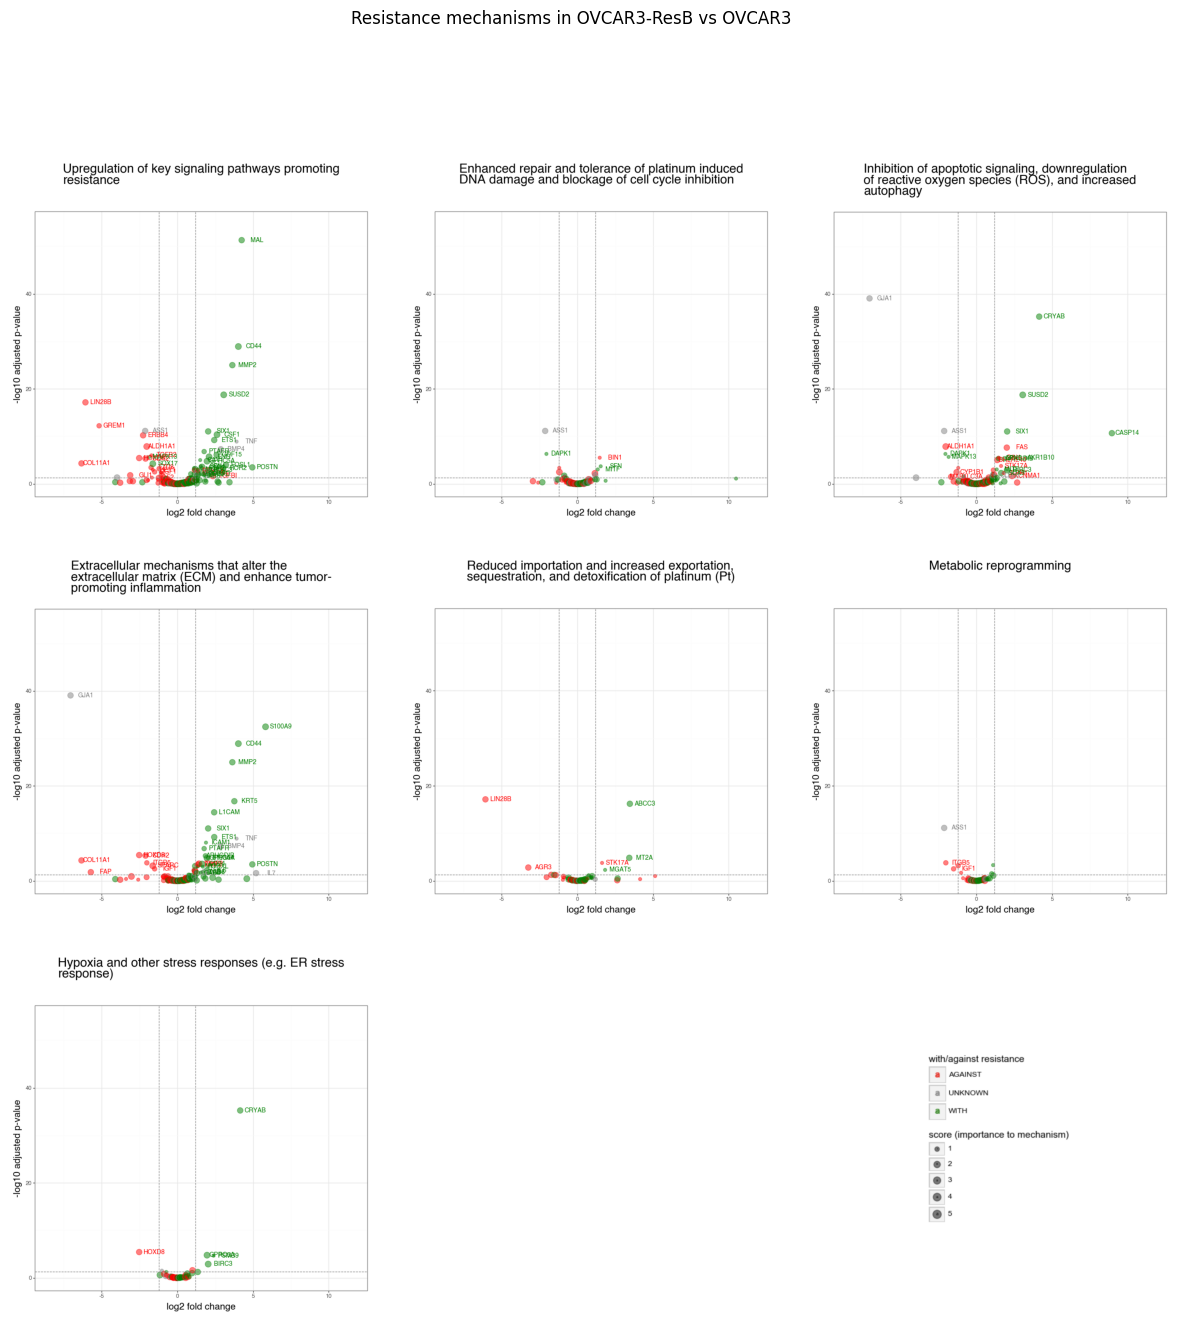

OVCAR4-ResA vs OVCAR4



/Users/Ryan/venv/general_purpose_venv/lib/python3.12/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 8 x 8 in image.
/Users/Ryan/venv/general_purpose_venv/lib/python3.12/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: plots/OVCAR4-ResA_vs_OVCAR4_Upregulation of key signaling pathways promoting resistance.svg
/Users/Ryan/venv/general_purpose_venv/lib/python3.12/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 8 x 8 in image.
/Users/Ryan/venv/general_purpose_venv/lib/python3.12/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: plots/OVCAR4-ResA_vs_OVCAR4_Enhanced repair and tolerance of platinum induced DNA damage and blockage of cell cycle inhibition.svg
/Users/Ryan/venv/general_purpose_venv/lib/python3.12/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 8 x 8 in image.
/Users/Ryan/venv/general_purpose_venv/lib/python3.12/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: plots/OVCAR4-ResA_vs_OVCAR4_In

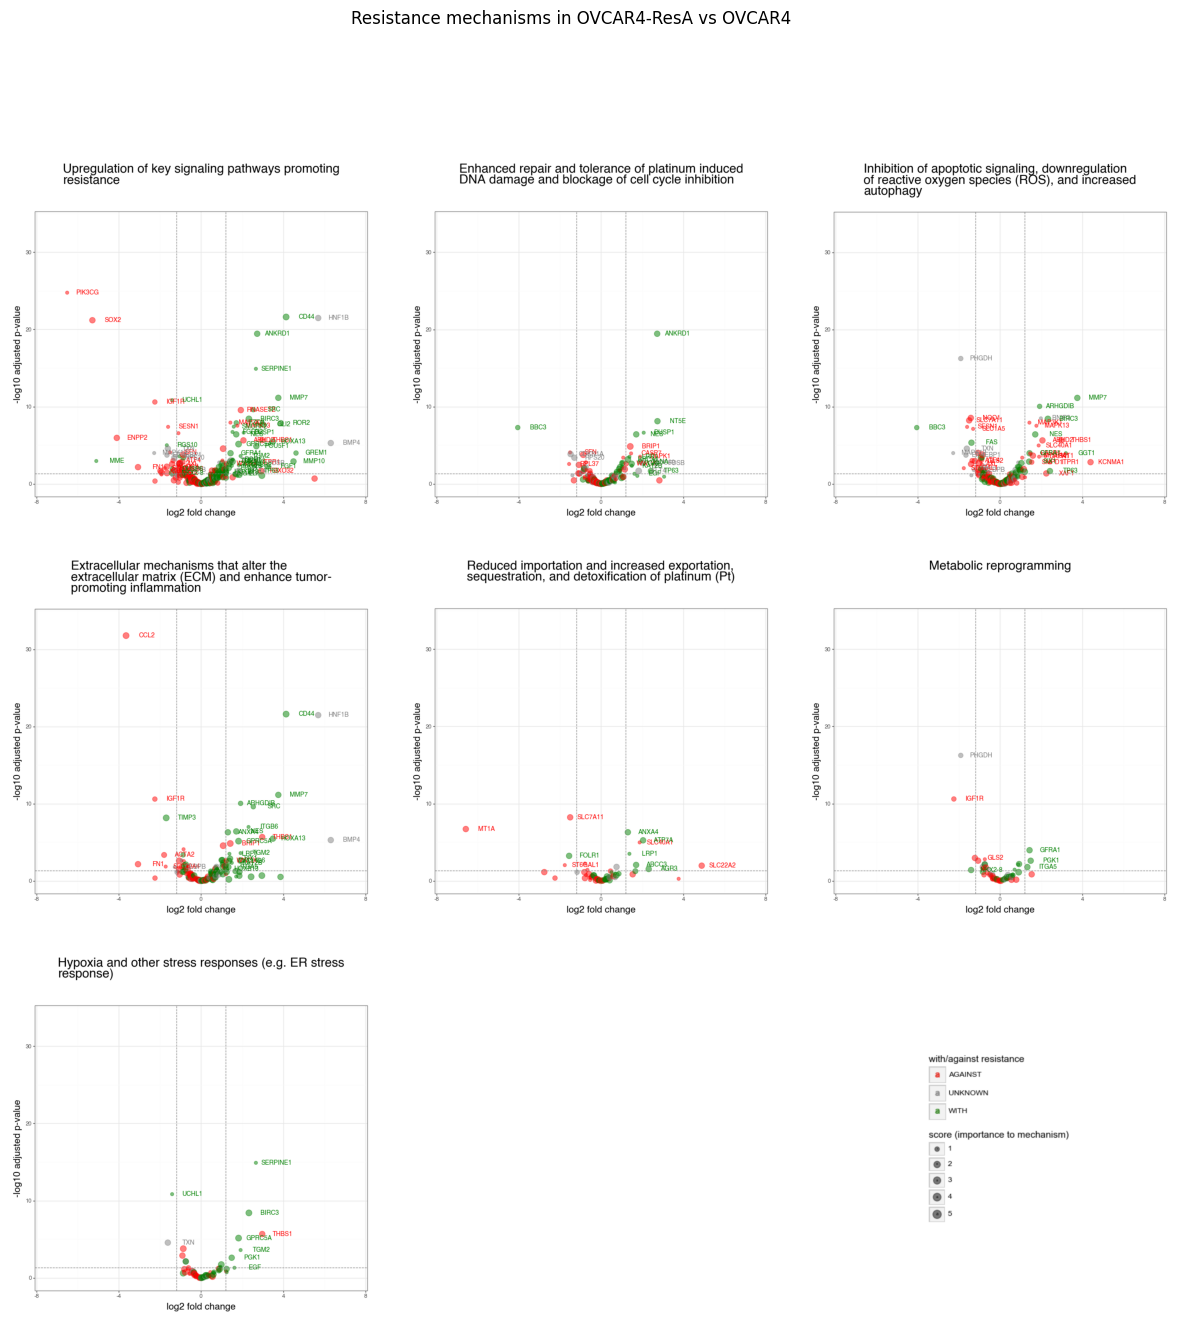

OVCAR4-ResB vs OVCAR4



/Users/Ryan/venv/general_purpose_venv/lib/python3.12/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 8 x 8 in image.
/Users/Ryan/venv/general_purpose_venv/lib/python3.12/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: plots/OVCAR4-ResB_vs_OVCAR4_Upregulation of key signaling pathways promoting resistance.svg
/Users/Ryan/venv/general_purpose_venv/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_text : Removed 1 rows containing missing values.
/Users/Ryan/venv/general_purpose_venv/lib/python3.12/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 8 x 8 in image.
/Users/Ryan/venv/general_purpose_venv/lib/python3.12/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: plots/OVCAR4-ResB_vs_OVCAR4_Enhanced repair and tolerance of platinum induced DNA damage and blockage of cell cycle inhibition.svg
/Users/Ryan/venv/general_purpose_venv/lib/python3.12/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 8 x

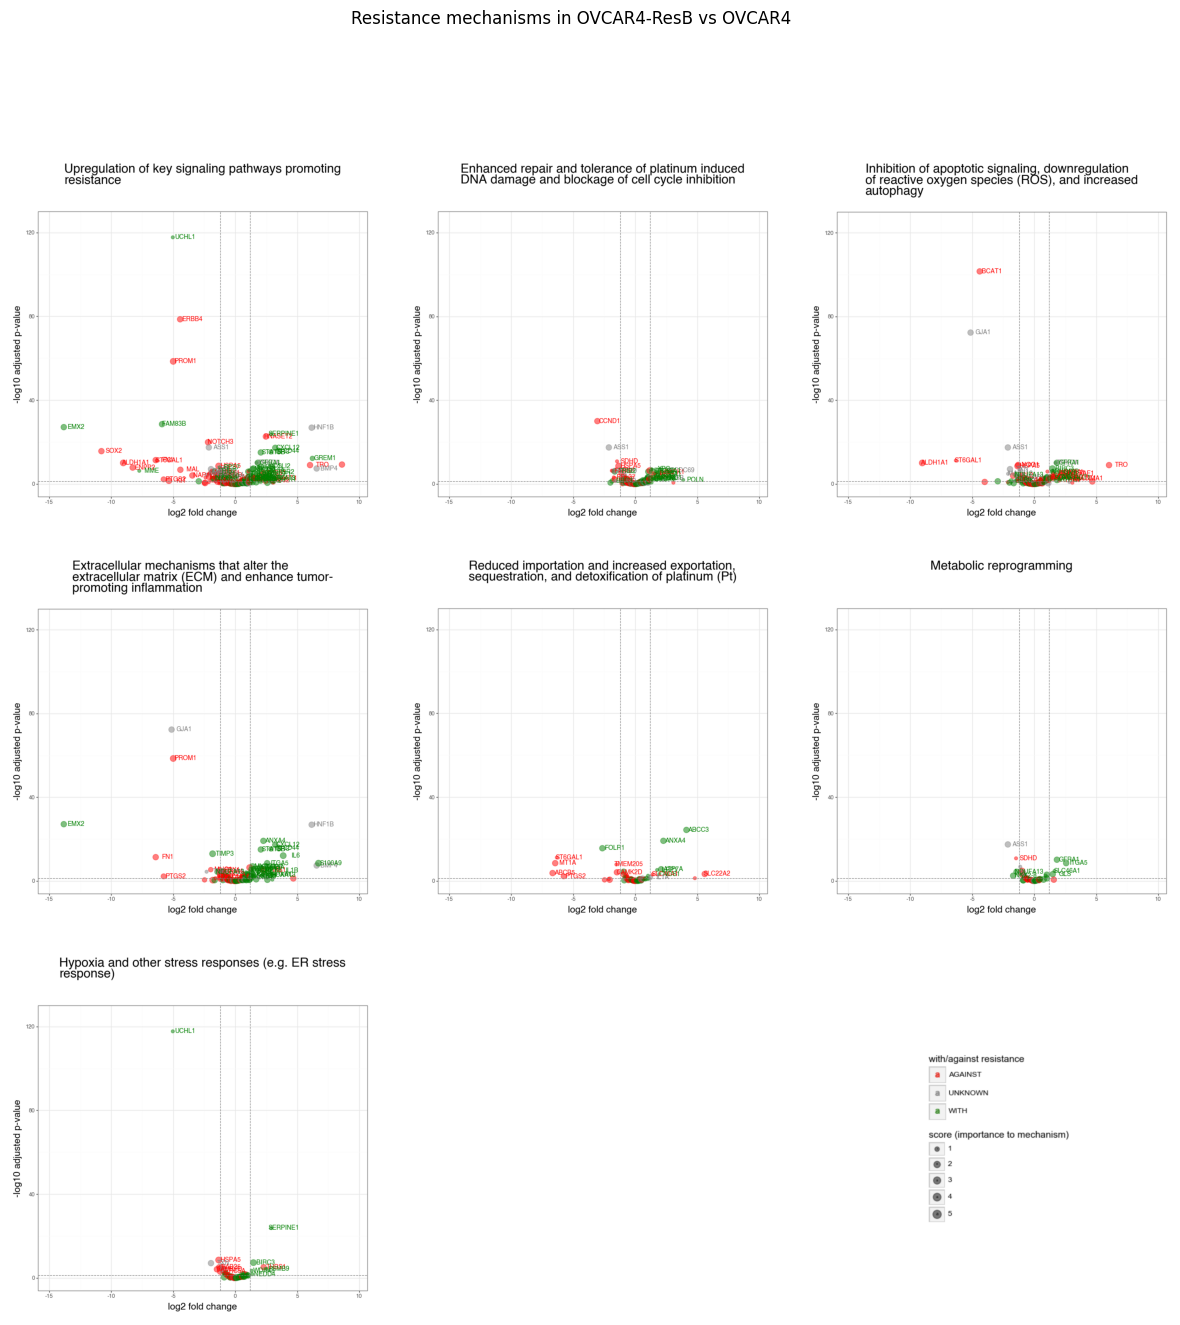

PEO4 vs PEO1



/Users/Ryan/venv/general_purpose_venv/lib/python3.12/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 8 x 8 in image.
/Users/Ryan/venv/general_purpose_venv/lib/python3.12/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: plots/PEO4_vs_PEO1_Upregulation of key signaling pathways promoting resistance.svg
/Users/Ryan/venv/general_purpose_venv/lib/python3.12/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 8 x 8 in image.
/Users/Ryan/venv/general_purpose_venv/lib/python3.12/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: plots/PEO4_vs_PEO1_Enhanced repair and tolerance of platinum induced DNA damage and blockage of cell cycle inhibition.svg
/Users/Ryan/venv/general_purpose_venv/lib/python3.12/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 8 x 8 in image.
/Users/Ryan/venv/general_purpose_venv/lib/python3.12/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: plots/PEO4_vs_PEO1_Inhibition of apoptotic signa

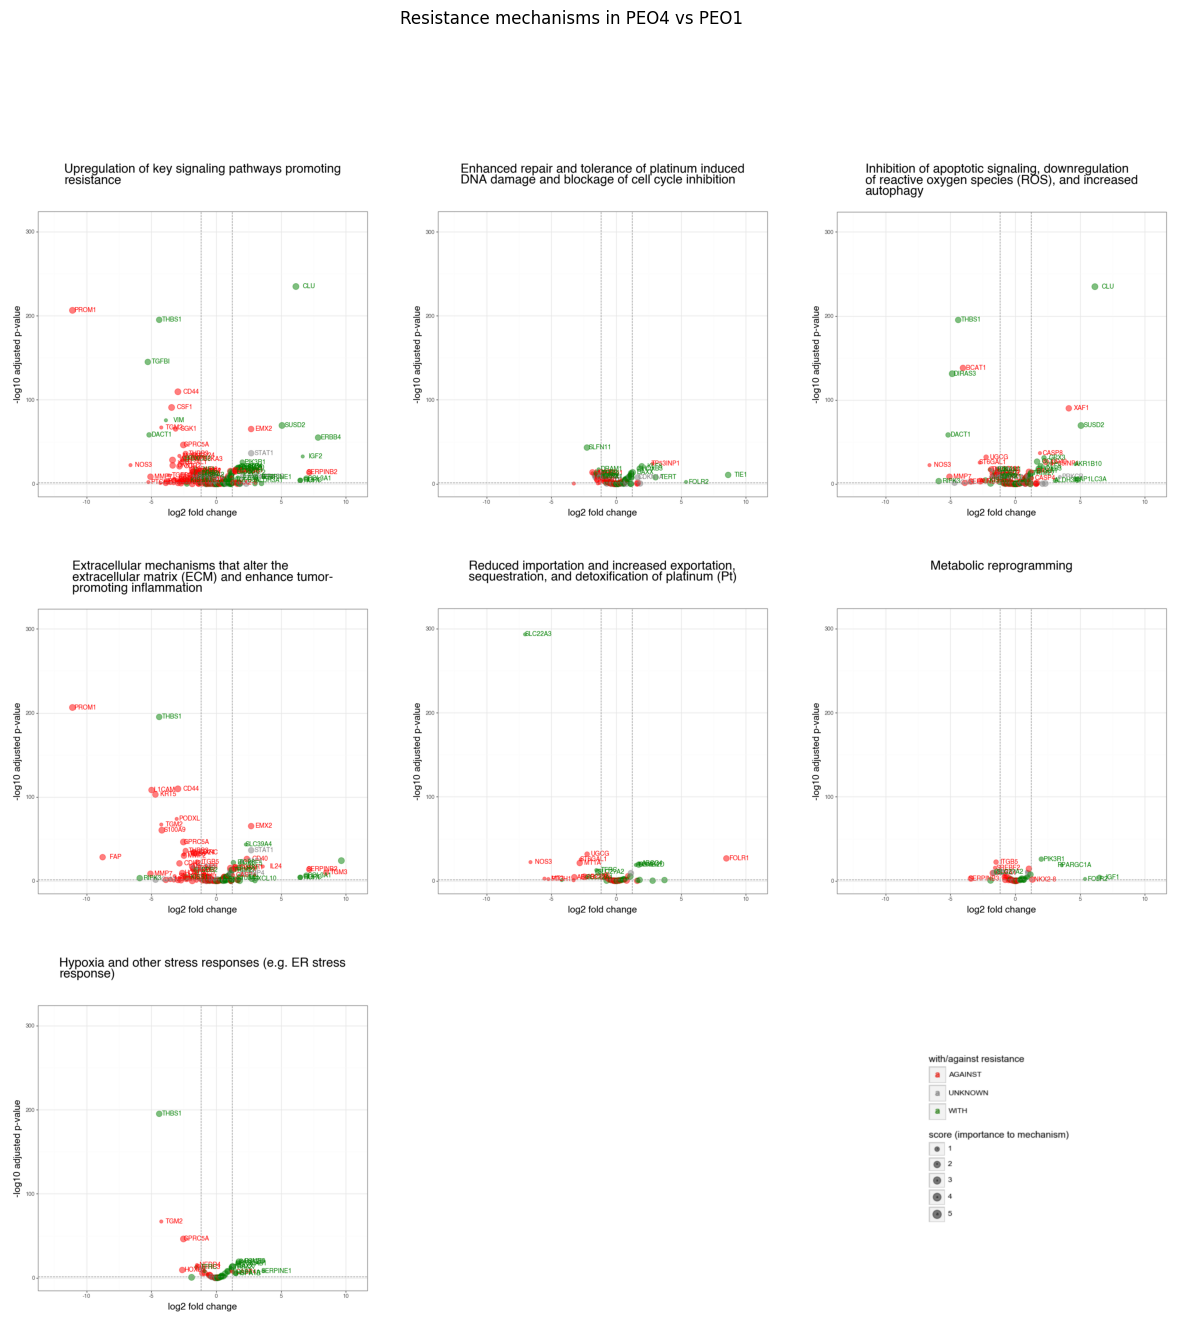

PEO6 vs PEO1



/Users/Ryan/venv/general_purpose_venv/lib/python3.12/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 8 x 8 in image.
/Users/Ryan/venv/general_purpose_venv/lib/python3.12/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: plots/PEO6_vs_PEO1_Upregulation of key signaling pathways promoting resistance.svg
/Users/Ryan/venv/general_purpose_venv/lib/python3.12/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 8 x 8 in image.
/Users/Ryan/venv/general_purpose_venv/lib/python3.12/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: plots/PEO6_vs_PEO1_Enhanced repair and tolerance of platinum induced DNA damage and blockage of cell cycle inhibition.svg
/Users/Ryan/venv/general_purpose_venv/lib/python3.12/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 8 x 8 in image.
/Users/Ryan/venv/general_purpose_venv/lib/python3.12/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: plots/PEO6_vs_PEO1_Inhibition of apoptotic signa

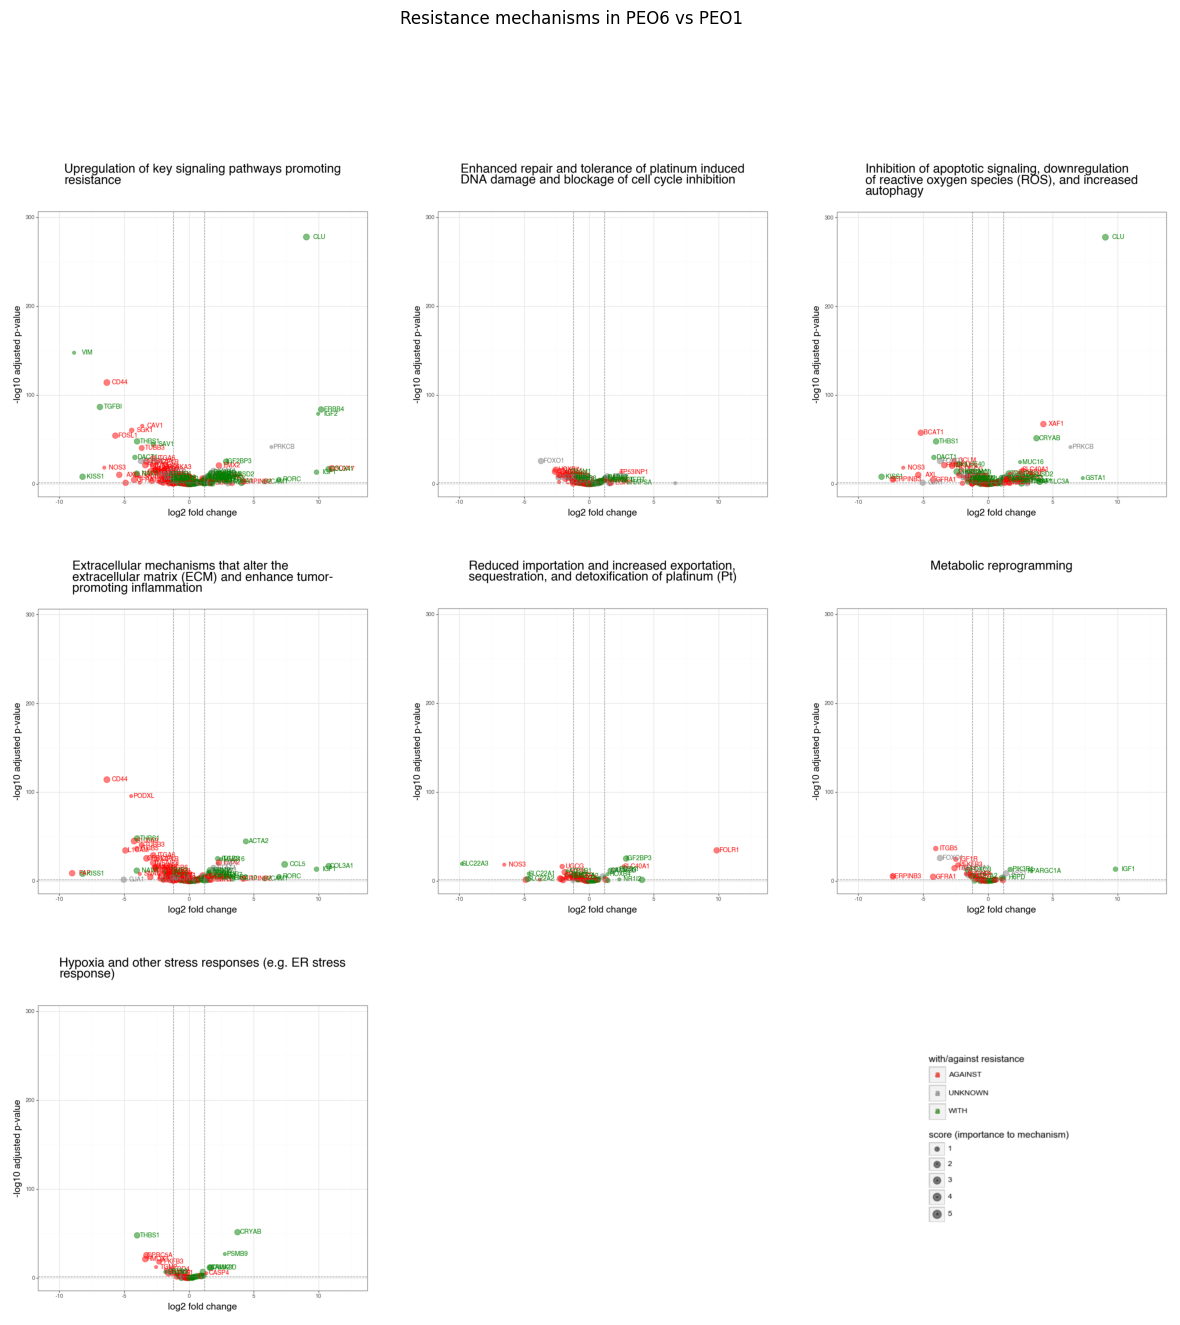

PEA2 vs PEA1



/Users/Ryan/venv/general_purpose_venv/lib/python3.12/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 8 x 8 in image.
/Users/Ryan/venv/general_purpose_venv/lib/python3.12/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: plots/PEA2_vs_PEA1_Upregulation of key signaling pathways promoting resistance.svg
/Users/Ryan/venv/general_purpose_venv/lib/python3.12/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 8 x 8 in image.
/Users/Ryan/venv/general_purpose_venv/lib/python3.12/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: plots/PEA2_vs_PEA1_Enhanced repair and tolerance of platinum induced DNA damage and blockage of cell cycle inhibition.svg
/Users/Ryan/venv/general_purpose_venv/lib/python3.12/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 8 x 8 in image.
/Users/Ryan/venv/general_purpose_venv/lib/python3.12/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: plots/PEA2_vs_PEA1_Inhibition of apoptotic signa

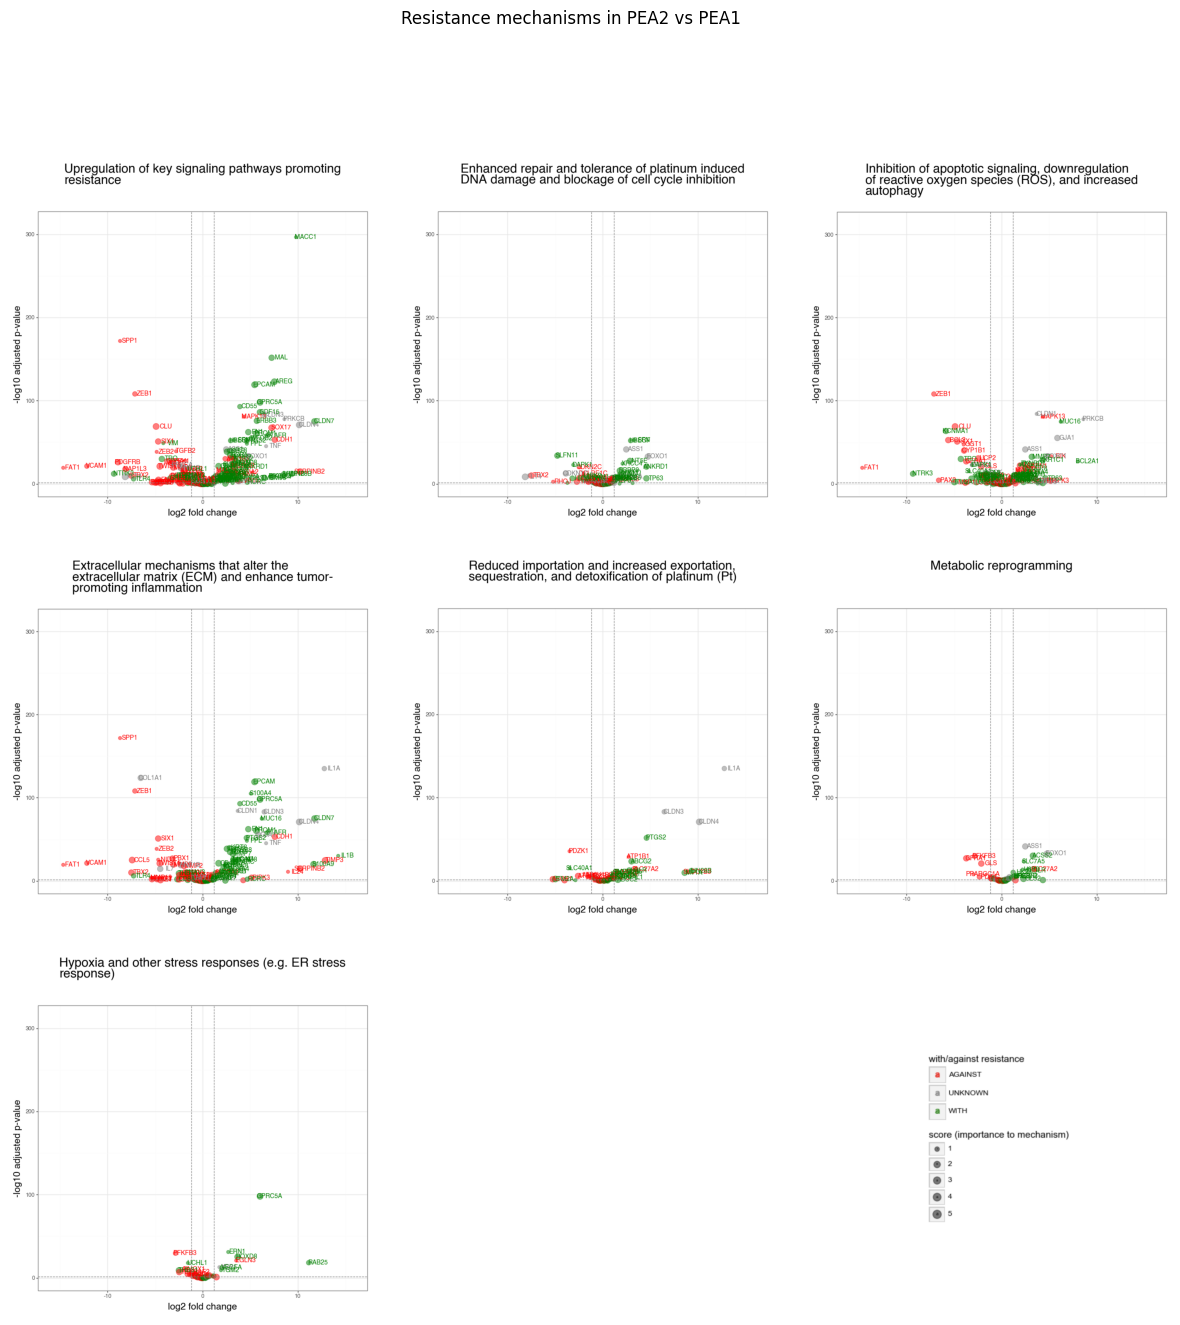

In [8]:
for isoline in isolines:
    for cellline in isoline.resistant_lines:
        print("=====================================================================")
        print(f"{cellline} vs {isoline.sensitive_line}")
        print("=====================================================================\n")

        # i = 0 # Plot number
        cellline_plots = []
        for group in group_counts_df["group of mechanisms"].tolist():
            plot = volcano_plot_mechanism(group, isoline.sensitive_line, cellline)
            plot.save(f"plots/{cellline}_vs_{isoline.sensitive_line}_{group}.svg")
            cellline_plots.append(plot)

        # Hacky way to display plots in a grid
        fig, axes = plt.subplots(3, 3, figsize=(15, 15))
        fig.suptitle(f"Resistance mechanisms in {cellline} vs {isoline.sensitive_line}")

        for ax in axes.flat:
            ax.axis("off")
        for i, plot in enumerate(cellline_plots):
            row = i // 3
            col = i % 3
            plot.save(f"temp/plot_{i}.png")
            image = plt.imread(f"temp/plot_{i}.png")
            axes[row, col].imshow(image)

        # Add legend
        legend = plt.imread("temp/legend.png")
        axes[2, 2].imshow(legend)

        plt.subplots_adjust(wspace=0.1)
        plt.subplots_adjust(hspace=0.1)
        # plt.savefig(f"plots/{cellline}_vs_{isoline.sensitive_line}_known_resistance_mechanism.svg")
        plt.show()